# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 3 : Simulation de la stabilité des segments au cours du temps

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


<!--TABLE OF CONTENTS-->
Contents:
  - [1.1 Rappel de la mission](#1.1-Rappel-de-la-mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
  - [1.4. Outils pour comparer des clusters](#1.4.-Outils-pour-comparer-des-clusters)
  - [1.5 Metriques de performance](#1.5-Metriques-de-performance)
  - [1.6 Visualisation des clusters](#1.6-Visualisation-des-clusters)
- [2. Import des données](#2.-Import-des-données)
- [3. Evaluation de la stabilité des segments](#3.-Evaluation-de-la-stabilité-des-segments)
  - [3.1 Formulation de la tâche](#3.1-Formulation-de-la-tâche)
  - [3.2 Choix des périods de temps à comparer](#3.2-Choix-des-périods-de-temps-à-comparer)
  - [3.3 Création des datasets](#3.3-Création-des-datasets)
  - [3.4 Pipeline pour model](#3.4-Pipeline-pour-model)
  - [3.5 Fit et prédictions sur model à t0 (clusters basé sur les données t0)](#3.5-Fit-et-prédictions-sur-model-à-t0-(clusters-basé-sur-les-données-t0))
  - [3.6 Statistiques sur les clusters](#3.6-Statistiques-sur-les-clusters)
  - [3.7 Estimation des périod de maintenance](#3.7-Estimation-des-périod-de-maintenance)
- [4. Evolution des clusters dans le temps](#4.-Evolution-des-clusters-dans-le-temps)
  - [4.2 Renommer les cluster ids en ordre de score pour la colonne](#4.2-Renommer-les-cluster-ids-en-ordre-de-score-pour-la-colonne)
  - [4.3 Noms des clusters pour chaque periode de temps](#4.3-Noms-des-clusters-pour-chaque-periode-de-temps)
  - [4.4 Evolution des clusters dans le temps (Sankey Diagram)](#4.4-Evolution-des-clusters-dans-le-temps-(Sankey-Diagram))
- [5. Tests sur l'effet de random_state, outliers et start_date sur la stabilité des clusters](#5.-Tests-sur-l'effet-de-random_state,-outliers-et-start_date-sur-la-stabilité-des-clusters)

## 1.1 Rappel de la mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn','scikit-learn', 
                       'param', 'holoviews'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import holoviews as hv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; sklearn==1.0.2; holoviews==1.14.8


### 1.2.3 Configuration défauts d'affichage


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
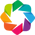

In [5]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab10")

set_config(display='diagram')
# displays HTML representation in a jupyter context

hv.extension('bokeh')


### 1.2.4 Quelque Constants


In [6]:
# On veut tester la stabilité des clusters
# Donc, il faut que l'initialisation des clusters est aléatoire
RANDOM_SEED = None

# Taille d'echantillon à utiliser pour scoring des models sur un ParameterGrid
SAMPLE_SIZE = 10000

# colonne qui reçoive les labels des clusters produit par la classification
CLUSTER_COL = 'cluster_id'

# colonne qui reçoive les pourcentages dans chaque cluster apres df.groupby(CLUSTER_COL)
# ou df[CLUSTER_COL].value_counts(normalize=True)
CLUSTER_PCT = 'cluster_pct'

# colonne pour ordonner les clusters (s'il est present), avant d'afficher en graphique
VALUE_COL = 'MonetaryValue'

# palette de couleurs pour les plots des clusters
# (pour d'autres graphiques on utilise tab10/tab20)
CLUSTER_PALETTE = 'nipy_spectral'

# les variables sélectionnées pour clustering
FEATURES = ['Frequency', 'MonetaryValue',
            'review_score', 'mean_nb_payments', 'delivery_delay']


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [7]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/simulation'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [8]:
def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [9]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


## 1.4. Outils pour comparer des clusters

(Procédures relevants copiés de P5_02_essais.ipynb)

A chaque fit des clusters, les clusters sont intialisés aléatoirement. En conséquance, leur identifiants change à chaque run.

Pour pouvoir interpreter et comparer les clusters, on peut:

- trier par un variable (exemple: par valeur monétaire); ou
- créer une 'score_total' pour chaque cluster, qui dépend des variables sélectionnées et de nos objectives

Un fois le score total calculé pour chaque cluster, on peut trier les clusters par ce score total:

- **Seg. 1** : cluster avec le plus haut score
- **Seg. 2** : cluster avec 2eme plus haut score
- etc.

**Création d'un score total**

Il faut _**standardiser**_ les variables utilisés pour calculer le score total, sinon une seule variable peut dominer les scores.


### 1.4.1 Aggregation des clusters


In [10]:
def agg_top(x):
    """return most frequent x"""
    return x if len(x) == 1 else x.value_counts().index[0]


def group_clusters(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    """Aggregate clusters on numeric and object columns"""
    df = df.copy().dropna(subset=[cluster_col])
    # set cluster_col as string to ensure correct joins
    # after groupby moves cluster_col to index
    df[cluster_col] = df[cluster_col].astype('str')

    # effectif et fréquence des clusters
    df_cluster_sizes = df.groupby(cluster_col).agg(
        cluster_size=(cluster_col, 'count'))
    n = len(df)
    df_cluster_sizes['cluster_pct'] = np.round(
        df_cluster_sizes['cluster_size']/n * 100, 2)

    # moyennes des colonnes numériques
    num_cols = list(
        df.drop(cluster_col, axis=1).select_dtypes('number').columns)
    df_cluster_means = df.groupby(cluster_col)[num_cols].mean()
    df_agg = df_cluster_sizes.join(df_cluster_means)

    #
    obj_cols = df.drop(cluster_col, axis=1).select_dtypes('object').columns
    if len(obj_cols) > 0:
        df_cluster_max = df.groupby(cluster_col)[obj_cols].agg(agg_top)
        df_agg = df_agg.join(df_cluster_max)

    if VALUE_COL in df_agg.columns:
        df_agg = df_agg.sort_values(by=VALUE_COL, ascending=False)
    df_agg = df_agg.reset_index()
    df_agg[cluster_col] = df_agg[cluster_col].astype(str)
    return df_agg


#### Données test


In [11]:
test_size = 200
df_test = pd.DataFrame({
    'cluster_id': np.random.randint(0, 6, 200),
    'montant': np.random.randint(20, 400, 200),
    'customer_state': np.random.choice(['SP', 'MG', 'RJ', 'SC', 'PR', 'RS'], 200)
})
df_test[VALUE_COL] = np.abs((3-df_test['cluster_id']**2)+np.random.random()*3)
df_test['review_score'] = np.abs(
    (4-df_test['cluster_id']**1.3)+np.random.random()*0.4)
group_clusters(df_test)

test_features = [VALUE_COL, 'montant', 'review_score']


### 1.4.2 Standardisation des échelles

Le plus simple c'est de noter chaque cluster dans une échelle de 1 à 5, pour chaque variable d'interêt. Ensuite, on peut comparer tous les variables sur un plot radar ou un lineplot ('snake plot')

Pour avoir les données à la même echelle, on applique le MinMaxScalar sur les means de chaque cluster.


In [12]:
from sklearn.preprocessing import MinMaxScaler


def standard_scores(df: pd.DataFrame, features=FEATURES,
                    scaler=None, min_score=1, max_score=5) -> pd.DataFrame:
    """
    Standardise scale of feature columns
    - Apply to cluster group summary for rapidity
    Returns dataframe with same columns, with feature scores standardised
    """
    ordered_columns = list(df.columns)
    features = cols_in_df(df, features)
    non_features = list(set(df.columns)-set(features))
    # Data Standardisation
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(min_score, max_score))
    df_std = pd.DataFrame(scaler.fit_transform(df[features]),
                          columns=list(df[features].columns),
                          index=df[features].index)

    # Concatenating the non-features
    df_std = pd.concat(
        [df[non_features], df_std], axis=1)

    # Reset column order
    df_std = df_std[ordered_columns]
    return df_std


df_test.pipe(group_clusters).pipe(standard_scores)


cluster_id  cluster_size  cluster_pct  montant  MonetaryValue  review_score  \
0          5            28        14.00   211.71           5.00          4.75   
1          4            45        22.50   209.49           3.05          2.79   
2          0            28        14.00   224.86           1.87          5.00   
3          1            34        17.00   237.21           1.65          4.04   
4          3            35        17.50   234.09           1.53          1.00   
5          2            30        15.00   213.13           1.00          2.64   

  customer_state  
0             SP  
1             PR  
2             MG  
3             RS  
4             RS  
5             RJ

### 1.4.3 Score total pour un cluster

On veut identifier les clusters produit par chaque model, pour faciliter l'interpretation.

Comme pour la segmentation RFM, on va utiliser **Fréquence** et valeur **Monétaire** . Le feature 'valeur monétaire' et le


In [13]:
def calc_total_score(df: pd.DataFrame, features=None):
    """
    Calculate and add/replace a total_score column, based on features
    - Apply to cluster group summary for rapidity
    Returns dataframe with same columns, with feature scores standardised
    """
    if features is None:
        features = cols_in_df(df, FEATURES)
    # Apply standardisation to features (no change if features are already standardised)
    df_std = standard_scores(df, features)
    # Add /replace column in non-standardised version
    df = df_std.copy()
    df['total_score'] = 0
    if 'MonetaryValue' in df_std.columns:
        if 'Frequency' in df_std.columns:
            df['total_score'] += np.multiply(
                df_std['MonetaryValue'], df_std['Frequency'])
        else:
            df['total_score'] += df_std['MonetaryValue']
    # else:
    if 'Frequency' in df_std.columns:
        df['total_score'] += df_std['Frequency']
    if 'delivery_delay' in df_std.columns:
        df['total_score'] -= df_std['delivery_delay']
    if 'review_score' in df_std.columns:
        df['total_score'] += df_std['review_score']
    return df


df_test.pipe(group_clusters).pipe(calc_total_score).set_index(
    CLUSTER_COL).sort_values(by='total_score', ascending=False)


cluster_size  cluster_pct  montant  MonetaryValue  review_score  \
cluster_id                                                                    
5                     28        14.00   211.71           5.00          4.75   
0                     28        14.00   224.86           1.87          5.00   
4                     45        22.50   209.49           3.05          2.79   
1                     34        17.00   237.21           1.65          4.04   
2                     30        15.00   213.13           1.00          2.64   
3                     35        17.50   234.09           1.53          1.00   

           customer_state  total_score  
cluster_id                              
5                      SP         9.75  
0                      MG         6.87  
4                      PR         5.84  
1                      RS         5.69  
2                      RJ         3.64  
3                      RS         2.53

In [14]:
# IMPORTANT : Mettre à jour SCORE_COLUMNS si les colonnes utilisés pour
# calculer le score_total change - ils sont utilisés par calc_cluster_order_score
SCORE_COLUMNS = ['MonetaryValue', 'Frequency',
                 'delivery_delay', 'review_score']


def calc_cluster_order_score(df: pd.DataFrame, cluster_col=CLUSTER_COL, score_cols=SCORE_COLUMNS):
    """
    Relabel clusters based on total_score for each cluster
    - 1. If dataframe df is full dataset, create a cluster_summary
    - 2. in cluster_summary, create a score_column and sort by cluster_score
    """
    if not cluster_col in df.columns:
        return sorted(list(df[cluster_col].unique()))
    n_clusters = df[cluster_col].nunique()

    # Step 1: Create summary table, if not supplied
    if len(df) > n_clusters:
        cols_to_group = cols_in_df(df, [*score_cols, cluster_col])
        df_groups_ = group_clusters(df[cols_to_group].reindex(), cluster_col)
    else:
        df_groups_ = df.copy()

    # if cluster_col is category (after groupby), convert to str
    df_groups_[cluster_col] = df_groups_[cluster_col].astype(str)
    # sort by cluster_score
    cluster_order = list(df_groups_
                         .pipe(calc_total_score)
                         .sort_values(by='total_score', ascending=False)
                         [cluster_col].astype(str))
    return cluster_order


df_test.pipe(calc_cluster_order_score)


['5', '0', '4', '1', '2', '3']

### 1.4.4 Renommer les clusters


In [15]:
def create_segment_map(df, segments=None, cluster_col=CLUSTER_COL) -> dict:
    cluster_labels = sorted(list(df[cluster_col].unique()))
    label_map = dict(zip(cluster_labels, segments))
    return label_map


def create_label_map(df, cluster_col=CLUSTER_COL) -> dict:
    """
    Create mapping for new labels, based on order_score
    - 1. Calculate cluster order based on a 'total_score' for cluster
    - 2. Create a dictionary label_map to map (cluster_id : new_labels)
    """
    df = df.dropna(subset=[cluster_col])
    cluster_order = calc_cluster_order_score(df, cluster_col)
    n_clusters = len(cluster_order)
    new_labels = [f'Seg {i}' for i in range(1, n_clusters+1)]
    label_map = dict(zip(cluster_order, new_labels))
    return label_map


def rename_cluster_labels(df: pd.DataFrame, label_map=None, cluster_col=CLUSTER_COL):
    """
    Rename cluster ids based on a 'total_score' for cluster
    1. if label_map is not provided:
       - create_label_map
    2. With provided or newly created label_map:
    - map the dictionary to replace cluster_id with new labels, making a backup column for debugging
    """
    if not cluster_col in df.columns:
        return df

    df = df.copy()
    df[cluster_col] = df[cluster_col].astype(str)
    df[cluster_col].fillna('no_cluster')

    if label_map is None:
        label_map = create_label_map(df, cluster_col)

    df = df.copy()
    df[f'{cluster_col}_bak'] = df[cluster_col]
    df[cluster_col] = df[cluster_col].astype(
        str).map(label_map).astype(str)
    return df


df_test.pipe(group_clusters).pipe(rename_cluster_labels).sort_values(
    by='cluster_id', ascending=True)


cluster_id  cluster_size  cluster_pct  montant  MonetaryValue  review_score  \
0      Seg 1            28        14.00   211.71          19.72          3.92   
2      Seg 2            28        14.00   224.86           5.28          4.18   
1      Seg 3            45        22.50   209.49          10.72          1.88   
3      Seg 4            34        17.00   237.21           4.28          3.18   
5      Seg 5            30        15.00   213.13           1.28          1.72   
4      Seg 6            35        17.50   234.09           3.72          0.01   

  customer_state cluster_id_bak  
0             SP              5  
2             MG              0  
1             PR              4  
3             RS              1  
5             RJ              2  
4             RS              3

## 1.5 Metriques de performance

### 1.5.2 Metriques d'un classifier


In [16]:
from sklearn.base import clone
from sklearn import metrics
from sklearn.cluster import KMeans


def performance_metrics(df: pd.DataFrame, labels, clf: KMeans, k, sample_size=10000, random_state=RANDOM_SEED):
    """
    Calculer les performance metrics pour un classifier qui et déja fitted (KMeans, DBSCAN, CAH etc)
    """
    df = df.copy()
    clf = clone(clf)
    n = min(len(df), sample_size)
    df['labels'] = labels
    df = df.sample(n=n, random_state=random_state)
    labels = df['labels'].values
    min_cluster_pct = df['labels'].value_counts(normalize=True).min()
    df = df.drop('labels', axis=1)
    res = {'k': k,
           'min_cluster_pct': round(min_cluster_pct*100, 2),
           'davies_bouldin': round(metrics.davies_bouldin_score(df, labels), 2),
           'calinski_harabasz': round(metrics.calinski_harabasz_score(df, labels), 2),
           'silhouette_score': round(metrics.silhouette_score(df, labels), 3)
           }
    if not clf is None:
        if hasattr(clf, 'inertia_'):
            res['distortion_score'] = round(getattr(clf, 'inertia_', 0), 0)
    return res


In [17]:
from sklearn.preprocessing import QuantileTransformer


def get_metrics(df, features, preprocessor=None, clf=None, cluster_col=CLUSTER_COL):
    """return performance for a given preprocessor and classifier"""
    if preprocessor is None:
        preprocessor = QuantileTransformer(output_distribution='normal')
    df_scaled = pd.DataFrame(
        preprocessor.fit_transform(df[features]),
        index=df.index,
        columns=features)
    metr = performance_metrics(
        df_scaled, df[cluster_col], clf=clf, k=df[cluster_col].nunique())
    return metr


### 1.5.2 Taille des clusters


In [18]:
def cluster_sizes(df, cluster_col=CLUSTER_COL, normalize=True):
    if normalize:
        return (df[cluster_col].value_counts(normalize=True).values*100).astype(int)
    else:
        return df[cluster_col].value_counts(normalize=False).values


## 1.6 Visualisation des clusters


### 1.6.2 Spider plots

Pour avoir les données au même echelle, on applique le MinMaxScalar sur les means de chaque cluster, avec un range de 1 à 5

- (n'utilise pas min = 0 : le spider devient invisible)


In [19]:
from math import pi
from matplotlib.figure import Figure
from matplotlib.projections import PolarAxes


def plot_spider(df_cluster_summary: pd.DataFrame, features=FEATURES,
                cluster_col=CLUSTER_COL, segment_labels=None):
    """
    Plot cluster summary as spider plots
    - cluster order based on 'total_score' column in cluster_summary
    Based on https://python-graph-gallery.com/390-basic-radar-chart
    """
    df_to_plot_std = standard_scores(
        df_cluster_summary, features, min_score=1, max_score=5)

    df_to_plot_std = (df_to_plot_std
                      .pipe(calc_total_score)
                      .pipe(rename_cluster_labels)
                      .sort_values(by=cluster_col)
                      .reset_index())

    if not segment_labels is None:
        old_labels = sorted(list(df_to_plot_std[cluster_col]))
        label_map = dict(zip(old_labels, segment_labels))
        df_to_plot_std[cluster_col] = df_to_plot_std[cluster_col].map(
            label_map)

    n_clusters = df_to_plot_std[cluster_col].nunique()

    color = sns.color_palette(CLUSTER_PALETTE, n_colors=n_clusters)

    # angles
    n_features = len(features)
    angles = [n / float(n_features) * 2 * pi for n in range(n_features)]
    angles += angles[:1]  # close plot

    n_cols = 4
    n_rows = n_clusters // n_cols + (n_clusters % n_cols > 0)
    fig: Figure = plt.figure(1, figsize=(n_cols*4, n_rows*4))

    segments = list(df_to_plot_std[cluster_col])
    # debug
    # print(df_to_plot_std[[cluster_col, 'cluster_pct',
    #       'total_score', 'MonetaryValue', 'Frequency']])

    for i, segment in enumerate(segments):
        ax: PolarAxes = fig.add_subplot(n_rows, n_cols, i + 1, polar=True)

        # We are going to plot the first line of the data frame.
        values = list(df_to_plot_std.loc[i][features].values)
        values += values[:1]  # repeat 1st feature to close radar plot
        pct = df_to_plot_std.loc[i]['cluster_pct']
        ax.set_title(f'{segment} ({pct:.1f} %)', color=color[i], fontdict={
                     "fontsize": 15, "fontweight": "bold"})
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], features, color="grey", size=8)
        ax.set_xticklabels(features, size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        ax.set_rlim((0, 5))
        # r axis is a transformation of the y_axis
        # ax.set_ylim((0,5))
        ax.set_rgrids(range(1, 5))

        # Plot data
        ax.plot(angles, values, color=color[i], marker="o", lw=1, ls="solid")

        # Fill area
        ax.fill(angles, values, color=color[i], alpha=.25)
    plt.subplots_adjust(hspace=0.25, wspace=1.02)

    pct = df_to_plot_std['cluster_pct'].to_dict()
    pct = {f'seg {k}': v for k, v in pct.items()}
    # pct = pd.DataFrame({f'seg {k}': v for k, v in pct.items()})

    return pct


In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline


def run_fit_spider(df: pd.DataFrame, features=FEATURES, model=None, k=7,
                   random_state=RANDOM_SEED, segment_labels=None):
    """Run model on df[features], then plot result as spider plot"""
    if model is None:
        model = Pipeline(steps=[
            ('preprocessor', QuantileTransformer(
                output_distribution='normal', random_state=random_state)),
            ('clf', KMeans(n_clusters=k, random_state=random_state))
        ])
   # fit les clusters
    clusters_ = df.copy()
    clusters_[CLUSTER_COL] = model.fit_predict(df[features])
    cluster_groups_ = group_clusters(clusters_)
    pct = plot_spider(cluster_groups_, features, segment_labels=segment_labels)
    preprocessor = model.named_steps['preprocessor']
    clf = model.named_steps['clf']
    metr = get_metrics(clusters_, features, preprocessor, clf)
    titre = f'k={k}, random_state={random_state}'
    plt.suptitle(f'{titre}{features}')
    return dict(**metr, **{'pct': pct})

# metr, _ = run_fit_spider(df_test, test_features, k=7)
# print(metr)


# 2. Import des données

Les essais ont montré que la bibliothèque KMeans ne marche pas quand le nombre de points est trop important (trop de RAM ?)
On limite l'analyse le nombre de points à 80000 pour éviter des résultats bizarres

Repétition avec plusieurs tailles de SAMPLE_SIZE entre 20000 et 80000 produit des résultats siilaires


In [21]:
OUT_DIR = 'data/out'
df_clients = pd.read_csv(f'{OUT_DIR}/clients.csv')
df_clients['dernier_achat'] = pd.to_datetime(df_clients['dernier_achat'])
sample_size = min(80000, len(df_clients))
df_clients = df_clients.sample(sample_size, random_state=RANDOM_SEED)
df_clients.head()


customer_unique_id       dernier_achat  Frequency  \
82263  e2ce734f0bd635b4b82317b5e5fcd152 2017-11-01 15:25:12          2   
77172  d4842aa226d96a1cce7414b48c1dba85 2018-07-07 14:02:43          1   
54957  97b27e8f7862217bae2f5bbc66e15b77 2018-05-18 19:56:54          1   
58473  a15630ebd61b2a42d78cb93fbebeda88 2017-08-08 21:04:16          1   
56928  9cfa9dd746cc855cc86fbd3b455ed20e 2017-06-29 15:27:53          1   

       MonetaryValue  Recency  mean_nb_payments  review_score  delivery_time  \
82263          80.15      349              2.00          4.00           9.00   
77172          32.43      101              1.00          1.00           5.00   
54957         227.66      151              2.00          5.00          25.00   
58473          97.87      434              1.00          4.00           5.00   
56928          42.59      474              2.00          4.00          10.00   

       delivery_delay  distance_customer_seller  freight_percent payment_mode  \
82263          -17.50                    645.09             0.20  credit_card   
77172           -6.00                     10.00             0.23       boleto   
54957          -20.00                    318.06             0.12  credit_card   
58473           -9.00                      9.56             0.08       boleto   
56928          -23.00                    290.61             0.30  credit_card   

      favourite_category customer_state favourite_seller_state  time_of_day  \
82263            leisure             RS                     SC        15.00   
77172        office_tech             SP                     SP        14.00   
54957    diy_garden_auto             RJ                     SP        19.00   
58473      health_parfum             SP                     SP        21.00   
56928    diy_garden_auto             SP                     SP        15.00   

       weekday  products_per_order  
82263     2.00                1.00  
77172     5.00                1.00  
54957     4.00                1.00  
58473     1.00                1.00  
56928     3.00                1.00

In [22]:
print(df_clients.columns)


Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'customer_state',
       'favourite_seller_state', 'time_of_day', 'weekday',
       'products_per_order'],
      dtype='object')


2016-10-03 16:56:50
{'k': 7, 'min_cluster_pct': 1.42, 'davies_bouldin': 1.05, 'calinski_harabasz': 12629.07, 'silhouette_score': 0.31, 'pct': {'seg 0': 1.47, 'seg 1': 1.52, 'seg 2': 25.38, 'seg 3': 13.39, 'seg 4': 31.91, 'seg 5': 16.81, 'seg 6': 9.53}}


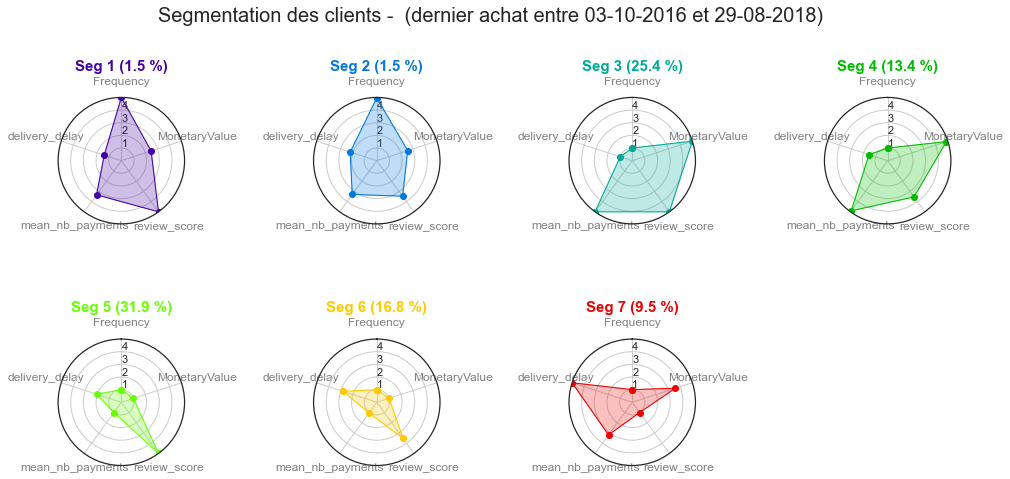

In [23]:
metr = run_fit_spider(df_clients, FEATURES, k=7)


def spider_title(df, k=7, periode=''):
    date_from = df['dernier_achat'].min()
    date_to = df['dernier_achat'].max()
    print(date_from)
    plt.suptitle(
        f"Segmentation des clients - {periode} (dernier achat entre {date_from:%d-%m-%Y} et {date_to:%d-%m-%Y})", fontsize=20)


spider_title(df_clients, k=7)
print(metr)


2016-10-03 16:56:50
"Segmentation_des_clients_-__(dernier_achat_entre_03-10-2016_et_29-08-2018).png"
{'k': 7, 'min_cluster_pct': 1.47, 'davies_bouldin': 1.04, 'calinski_harabasz': 12857.65, 'silhouette_score': 0.318, 'pct': {'seg 0': 1.47, 'seg 1': 1.52, 'seg 2': 25.79, 'seg 3': 13.72, 'seg 4': 31.5, 'seg 5': 16.48, 'seg 6': 9.53}}


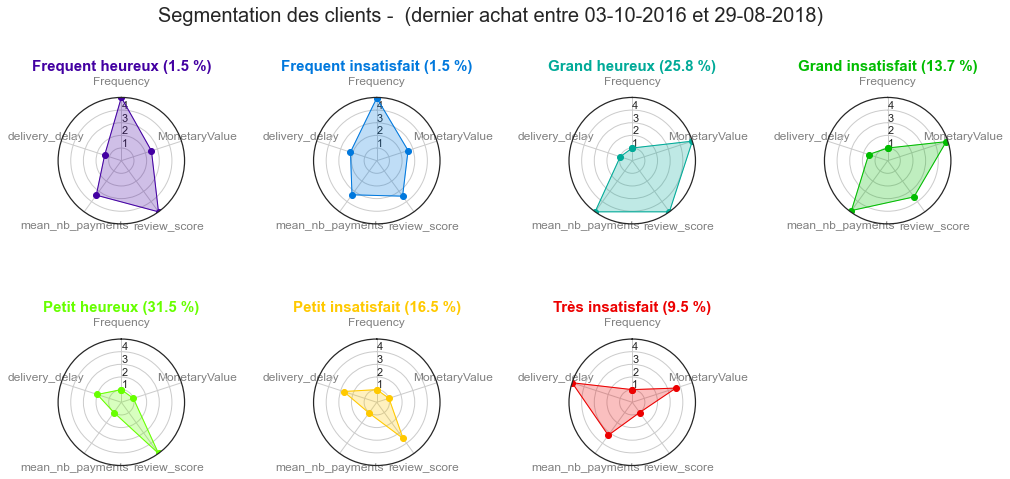

In [24]:
SEGMENT_LABELS = [
    'Frequent heureux',
    'Frequent insatisfait',
    'Grand heureux',
    'Grand insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Très insatisfait'
]
metr = run_fit_spider(df_clients, FEATURES, k=7, segment_labels=SEGMENT_LABELS)
spider_title(df_clients, k=7)
to_png()
print(metr)


# 3. Evaluation de la stabilité des segments

## 3.1 Formulation de la tâche

### 3.1.1 Le modèle devient obsolète après combien de temps ?

L’objectif est de déterminer au bout de **combien de temps**

- le modèle de clustering entraîné initialement proposé (donc « fit ») devient obsolète
- (quand les prédictions, « predict », ne sont plus pertinentes),
- nécessitant d’entraîner un nouveau modèle de clustering.


### 3.1.2 Comparaisons à faire

On va comparer les clusters à un temps **t1** des données (**df_t1**), selon que l’on utilise

- les clusters d'un modèle **model_m0** initial, créé à **t0** via un **« predict »**
- les clusters d'un modèle **model_m1**, créé à temps **t1** via un **« fit »**.


### 3.1.3 Calcul de le score ARI

Le score ARI (Adjusted Rand Index) est un mesure de quel pourcentage de points reste dans les mêmes clusters

- Si l’ARI passe en dessous de 0.8 (correspond environ à 0,9 en accuracy), il est sûrement pertinent de reproposer un entraînement de modèle au client.

Pour afficher l'evolution du score ARI, il faut simuler plusieurs périodes t1, t2 ... tN, et

Pour calculer le score ARI (pour la **stabilité des clusters**), on va comparer:

- A t0: **model_t0**.fit(df_t0).**predict(df_t0)** vs **model_t0.fit(df_t0)** (identique, ARI=1)
- A t1: **model_t0**.fit(df_t0).**predict(df_t1)** vs **model_t1.fit(df_t1)**
- A t2: **model_t0**.fit(df_t0).**predict(df_t2)** vs **model_t2.fit(df_t2)**
- A tN: **model_t0**.fit(df_t0).**predict(df_tN)** vs **model_tN.fit(df_tN)**


## 3.2 Choix des périods de temps à comparer

### 3.2.1 Des mois de données disponibles


In [25]:
print(df_clients['dernier_achat'].min())
print(df_clients['dernier_achat'].max())
print(df_clients['dernier_achat'].dtype)


2016-10-03 16:56:50
2018-08-29 15:00:37
datetime64[ns]


In [26]:
df_clients['dernier_achat'] = pd.to_datetime(df_clients['dernier_achat'])
print(df_clients['dernier_achat'].dtype)


datetime64[ns]


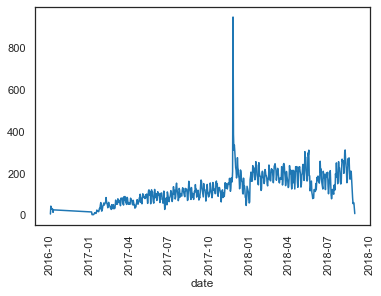

In [27]:
df_clients['date'] = df_clients['dernier_achat'].dt.date
df_clients.groupby('date')['customer_unique_id'].count().plot(kind='line')
plt.xticks(rotation=90)
plt.show()


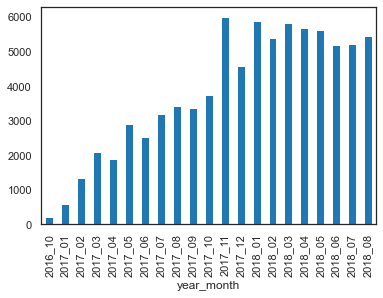

In [28]:
df_clients['year_month'] = df_clients['dernier_achat'].dt.strftime('%Y_%m')
df_clients.groupby('year_month')['customer_unique_id'].count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()


### 3.2.2 Des prévisions à comparer sont basées sur un période de 12 mois de données

On va comparer des prévisions basé sur 12 mois de données, pour minimiser les fluctuations saisonnières

Les données entières sont disponibles pour 18 mois, du 01/01/2017 à 01/08/2018 (données avant janvier 2017 sont trop éparses; données d'aout 2018 ne sont pas complets car il y a les achats pas encore livrés)


## 3.3 Création des datasets


### 3.3.1 Creation de Date Filters

Dans df_cients, on crée des colonnes pour filtrer les données par intervals de dates

**Set index to customer_unique_id**

Les données de t0 et de tN ne sont tous des mêmes clients.

Pour comparer l'evolution du segment attribué à chaque client, on define l'index comme _customer_unique_id_, facilitant le join des tables des previsions


In [29]:
df_clients = df_clients.set_index('customer_unique_id')


In [30]:
from datetime import datetime
# t0
START_DATE: datetime = pd.to_datetime('01/02/2017', format='%d/%m/%Y')


def one_year_dataset(df, start_date=START_DATE, nom_col='t0', date_col='dernier_achat'):
    end_date = start_date.replace(year=start_date.year+1)
    # print(f'data from {start_date:%d-%m-%Y} to {end_date:%d-%m-%Y}')
    df = df.copy()
    df[nom_col] = ((df[date_col] > start_date) & (df[date_col] < end_date))
    return df


dates = {}
for i in range(0, 7):
    dates[f't{i}'] = START_DATE + pd.DateOffset(months=i)

for key in dates:
    print(f'{key} : {dates[key]:%d-%m-%Y}')


t0 : 01-02-2017
t1 : 01-03-2017
t2 : 01-04-2017
t3 : 01-05-2017
t4 : 01-06-2017
t5 : 01-07-2017
t6 : 01-08-2017


In [31]:
def create_date_filter_columns(df, startdates: dict = dates):
    df = df.copy()
    for key in startdates:
        df = df.pipe(one_year_dataset, startdates[key], key)
        nb_clients = df[key].sum()
        dmin = df[df[key]]['dernier_achat'].min()
        dmax = df[df[key]]['dernier_achat'].max()
        print(
            f'{key} : from {dmin:%d-%m-%Y} to {dmax:%d-%m-%Y} ({nb_clients} unique customer ids)')
    return df


df_clients = df_clients.pipe(create_date_filter_columns)

selected_cols = ['dernier_achat', *dates.keys()]

df_clients[selected_cols].head()


t0 : from 01-02-2017 to 31-01-2018 (40868 unique customer ids)
t1 : from 01-03-2017 to 28-02-2018 (44898 unique customer ids)
t2 : from 01-04-2017 to 31-03-2018 (48643 unique customer ids)
t3 : from 01-05-2017 to 30-04-2018 (52450 unique customer ids)
t4 : from 01-06-2017 to 31-05-2018 (55182 unique customer ids)
t5 : from 01-07-2017 to 30-06-2018 (57828 unique customer ids)
t6 : from 01-08-2017 to 31-07-2018 (59848 unique customer ids)


dernier_achat     t0     t1     t2  \
customer_unique_id                                                          
e2ce734f0bd635b4b82317b5e5fcd152 2017-11-01 15:25:12   True   True   True   
d4842aa226d96a1cce7414b48c1dba85 2018-07-07 14:02:43  False  False  False   
97b27e8f7862217bae2f5bbc66e15b77 2018-05-18 19:56:54  False  False  False   
a15630ebd61b2a42d78cb93fbebeda88 2017-08-08 21:04:16   True   True   True   
9cfa9dd746cc855cc86fbd3b455ed20e 2017-06-29 15:27:53   True   True   True   

                                     t3     t4     t5     t6  
customer_unique_id                                            
e2ce734f0bd635b4b82317b5e5fcd152   True   True   True   True  
d4842aa226d96a1cce7414b48c1dba85  False  False  False   True  
97b27e8f7862217bae2f5bbc66e15b77  False   True   True   True  
a15630ebd61b2a42d78cb93fbebeda88   True   True   True   True  
9cfa9dd746cc855cc86fbd3b455ed20e   True   True  False  False

In [32]:

print(len(df_clients))
print(len(df_clients[df_clients['t0']]))
print(len(df_clients[df_clients['t1']]))
print(len(df_clients[df_clients['t0'] & df_clients['t1']]))


80000
40868
44898
39521


### 3.3.2 Création de datasets séparés

Pour faciliter l'évaluation de performance de chaque model, et pour lisibilité du code, on crée un copie de chaque dataset


In [33]:
def factory_one_year_dataset(df: pd.DataFrame,
                             start_date=START_DATE,
                             date_col='dernier_achat') -> pd.DataFrame:
    end_date = start_date.replace(year=start_date.year+1)
    # print(f'data from {start_date:%d-%m-%Y} to {end_date:%d-%m-%Y}')
    return df[(df[date_col] > start_date) & (df[date_col] < end_date)]


### 3.3.3 Nombre de clients commun entre les datasets


In [34]:

def check_factory_datasets(df):
    df_t0 = factory_one_year_dataset(df, START_DATE)
    print(f't0.shape : {df_t0.shape}')
    df_t1 = factory_one_year_dataset(df, START_DATE + pd.DateOffset(months=1))
    print(f't1.shape : {df_t1.shape}')
    df_t2 = factory_one_year_dataset(df, START_DATE + pd.DateOffset(months=2))
    print(f't1.shape : {df_t2.shape}')
    df_t3 = factory_one_year_dataset(df, START_DATE + pd.DateOffset(months=3))
    print(f't3.shape : {df_t3.shape}')
    df_t4 = factory_one_year_dataset(df, START_DATE + pd.DateOffset(months=4))
    print(f't5.shape : {df_t4.shape}')
    df_t5 = factory_one_year_dataset(df, START_DATE + pd.DateOffset(months=5))
    print(f't5.shape : {df_t5.shape}')
    df_t6 = factory_one_year_dataset(df, START_DATE + pd.DateOffset(months=6))
    print(f't6.shape : {df_t6.shape}')

    df_clients_communs = pd.DataFrame.from_dict({
        't0': len(df_t0),
        't0_t1': len(df_t0.index.intersection(df_t1.index)),
        't0_t2': len(df_t0.index.intersection(df_t2.index)),
        't0_t3': len(df_t0.index.intersection(df_t3.index)),
        't0_t4': len(df_t0.index.intersection(df_t4.index)),
        't0_t5': len(df_t0.index.intersection(df_t5.index)),
        't0_t6': len(df_t0.index.intersection(df_t6.index))
    }, orient='index', columns={'clients_communs'})
    return df_clients_communs


check_factory_datasets(df_clients).style.bar(vmin=0)


t0.shape : (40868, 26)
t1.shape : (44898, 26)
t1.shape : (48643, 26)
t3.shape : (52450, 26)
t5.shape : (55182, 26)
t5.shape : (57828, 26)
t6.shape : (59848, 26)


#### Datasets via DateFilter colonnes

Avec les boolean date filter colonnes [t0, t1, t2,...], il n'y a pas besoin de créer des jeux de données séparés


In [35]:
def en_commun(df, date_cols=dates.keys()):
    intersect = {}
    for col in date_cols:
        intersect[f't0_{col}'] = (df['t0'] & df[col]).sum()
    return pd.DataFrame.from_dict(intersect, orient='index', columns={'clients_communs'})


en_commun(df_clients).style.bar(vmin=0)


### 3.3.4 Visualisation d'un fit du model sur seulement 12 mois de données

Verification que 12 mois de données produit des segments similaires à ceux trouvés dans les données entières.


2017-02-01 08:45:22
"Segmentation_des_clients_-_T0_(dernier_achat_entre_01-02-2017_et_31-01-2018).png"
{'k': 7, 'min_cluster_pct': 2.55, 'davies_bouldin': 0.65, 'calinski_harabasz': 15129.68, 'silhouette_score': 0.661, 'pct': {'seg 0': 2.62, 'seg 1': 29.75, 'seg 2': 16.44, 'seg 3': 27.41, 'seg 4': 14.75, 'seg 5': 5.08, 'seg 6': 3.96}}


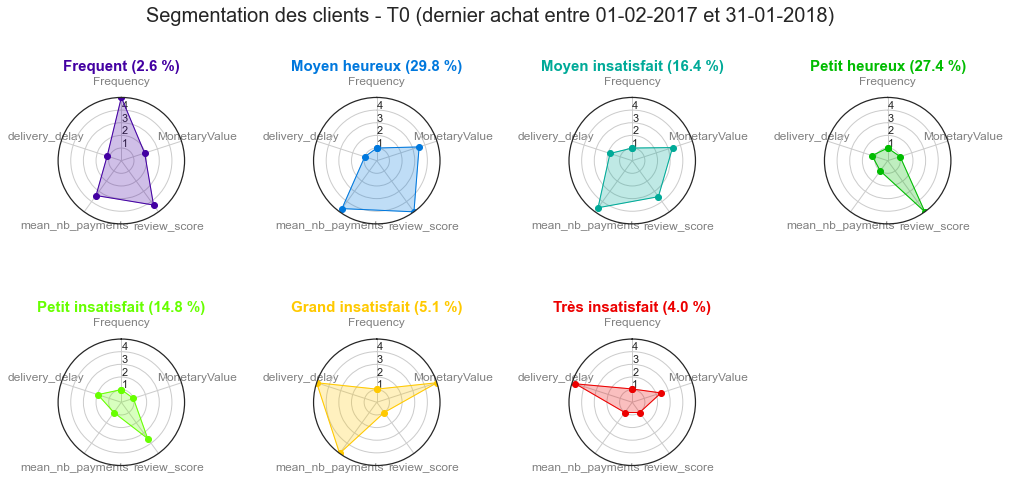

In [36]:
SEGMENT_LABELS_T0 = [
    'Frequent',
    'Moyen heureux',
    'Moyen insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Grand insatisfait',
    'Très insatisfait'
]


def plot_spider_one_year_data(df, periode='T0',
                              start_date=START_DATE,
                              segment_labels=None,
                              features=FEATURES, k=7):
    data = factory_one_year_dataset(df, start_date)
    metr = run_fit_spider(data, features, k=k, segment_labels=segment_labels)
    spider_title(data, k=k, periode=periode)
    to_png()
    return metr


metr = plot_spider_one_year_data(df_clients, 'T0',
                                 START_DATE,
                                 SEGMENT_LABELS_T0)
print(metr)


### 3.3.5 Elimination des outliers

Pour éviter l'influence des outliers sur les prévisions, on va

- utiliser l'isolation forest pour éxclure les outliers de fit de clustering.
- utiliser le QuantileTransformer (qui reduit l'influence de skew)


In [37]:
from sklearn.ensemble import IsolationForest


def find_outliers(df, num_cols=None, alpha=0.005, random_state=RANDOM_SEED):
    df = df.copy()
    if num_cols is None:
        num_cols = df.select_dtypes('number').columns
    model = IsolationForest(contamination=alpha, random_state=random_state)
    model.fit(df[num_cols].values)
    # outliers=model.predict(df[num_cols]<0)
    # enregistre comme une colonne non-numérique
    df['outlier'] = np.where(model.predict(
        df[num_cols].values) < 0, 'yes', 'no')
    return df


def drop_outliers(df):
    if 'outlier' in df.columns:
        return df[~(df['outlier'] == 'yes')].drop('outlier', axis=1)
    return df


print(df_clients.pipe(factory_one_year_dataset, START_DATE).shape)
print(df_clients[df_clients['t0']].shape)
(df_clients
 .pipe(factory_one_year_dataset, START_DATE)
 .pipe(find_outliers)
 .pipe(drop_outliers)).shape


(40868, 26)
(40868, 26)


(40663, 26)

## 3.4 Pipeline pour model


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

RANDOM_SEED = None

MODEL = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])


In [39]:
from copy import deepcopy
FEATURES = ['Frequency', 'MonetaryValue',
            'review_score', 'mean_nb_payments', 'delivery_delay']


def run_fit_model(df, model_, features=FEATURES, k=7, cluster_col=CLUSTER_COL,
                  remove_outliers_during_fit=True, percent_outliers=0.005,
                  random_state=RANDOM_SEED):
    # créer un index pour trier les resultats
    df = df.copy().reset_index()
    params = {'clf__n_clusters': k, 'clf__random_state': random_state}
    model_.set_params(**params)

    if percent_outliers <= 0:
        remove_outliers_during_fit = False
    if remove_outliers_during_fit:
        df = df.pipe(find_outliers, num_cols=features,
                     alpha=percent_outliers, random_state=random_state)
        df_outliers = df[df['outlier'] == 'yes']
        df = df[df['outlier'] != 'yes']

    model_.fit(df[features])
    clf = model_.named_steps['clf']
    df[cluster_col] = clf.labels_

    if remove_outliers_during_fit:
        # si les outliers ont été exclu du fit, il faut maintenant les ajoutés de retour au model
        df_outliers[cluster_col] = model_.predict(df_outliers[features])
        df = df.append(df_outliers, ignore_index=False)

    df[cluster_col] = df[cluster_col].astype(int).astype(str)

    # remettre les lignes dans l'ordre original
    df = df.sort_index().set_index('customer_unique_id')

    return df, deepcopy(model_)


## 3.5 Fit et prédictions sur model à t0 (clusters basé sur les données t0)

On veut savoir comment les prédictions basé sur model t0 changent dans le temps

Donc on veut comparer:

- les clusters **fit** a t0 : 01/02/2018
- les clusters **fit** à t1 (1 mois après) vs. clusters **predict** par t0
- les clusters **fit** à t3 (3 mois après) vs. clusters **predict** par t0
- les clusters **fit** à t6 (6 mois après) vs. clusters **predict** par t0


In [40]:
def fit_models_tn_predict_model_t0(df, model=MODEL, features=FEATURES, k=7,
                                   start_date=START_DATE, months=8):
    """
    Fit clusters for each month (based on previous year of data), 
    and predict clusters for each month based on 1 year of data at start_date"""
    df = df.copy()

    # ---------------------------------------------
    # select t0 data
    df_t0 = factory_one_year_dataset(df, start_date)
    # fit t0 clusters based on data at t0
    df_t0, fitted_model_t0 = run_fit_model(
        df_t0, model, FEATURES, k=k, cluster_col='fit_t0')
    df_t0['pred_t0'] = fitted_model_t0.predict(df_t0[features]).astype(str)
    df = df.join(df_t0[['fit_t0', 'pred_t0']])

    # repeat for other data
    for i in range(1, months+1):
        print(f'fit at t{i}, predict values at t{i} from model at t0')
        # select t1 data
        df_ti = factory_one_year_dataset(
            df, start_date+pd.DateOffset(months=i))
        # fit t{i} clusters based on data at t{i}
        df_ti, _ = run_fit_model(
            df_ti, model, FEATURES, k=k, cluster_col=f'fit_t{i}')
        # predict t{i} clusters based on (old) model at t0
        df_ti[f'pred_t{i}'] = fitted_model_t0.predict(
            df_ti[features]).astype(str)
        df = df.join(df_ti[[f'fit_t{i}', f'pred_t{i}']])

    return df


df_clusters = df_clients.pipe(fit_models_tn_predict_model_t0, months=7)


fit at t1, predict values at t1 from model at t0
fit at t2, predict values at t2 from model at t0
fit at t3, predict values at t3 from model at t0
fit at t4, predict values at t4 from model at t0
fit at t5, predict values at t5 from model at t0
fit at t6, predict values at t6 from model at t0
fit at t7, predict values at t7 from model at t0


In [41]:
df_clusters.head()


dernier_achat  Frequency  \
customer_unique_id                                                
e2ce734f0bd635b4b82317b5e5fcd152 2017-11-01 15:25:12          2   
d4842aa226d96a1cce7414b48c1dba85 2018-07-07 14:02:43          1   
97b27e8f7862217bae2f5bbc66e15b77 2018-05-18 19:56:54          1   
a15630ebd61b2a42d78cb93fbebeda88 2017-08-08 21:04:16          1   
9cfa9dd746cc855cc86fbd3b455ed20e 2017-06-29 15:27:53          1   

                                  MonetaryValue  Recency  mean_nb_payments  \
customer_unique_id                                                           
e2ce734f0bd635b4b82317b5e5fcd152          80.15      349              2.00   
d4842aa226d96a1cce7414b48c1dba85          32.43      101              1.00   
97b27e8f7862217bae2f5bbc66e15b77         227.66      151              2.00   
a15630ebd61b2a42d78cb93fbebeda88          97.87      434              1.00   
9cfa9dd746cc855cc86fbd3b455ed20e          42.59      474              2.00   

                                  review_score  delivery_time  delivery_delay  \
customer_unique_id                                                              
e2ce734f0bd635b4b82317b5e5fcd152          4.00           9.00          -17.50   
d4842aa226d96a1cce7414b48c1dba85          1.00           5.00           -6.00   
97b27e8f7862217bae2f5bbc66e15b77          5.00          25.00          -20.00   
a15630ebd61b2a42d78cb93fbebeda88          4.00           5.00           -9.00   
9cfa9dd746cc855cc86fbd3b455ed20e          4.00          10.00          -23.00   

                                  distance_customer_seller  freight_percent  \
customer_unique_id                                                            
e2ce734f0bd635b4b82317b5e5fcd152                    645.09             0.20   
d4842aa226d96a1cce7414b48c1dba85                     10.00             0.23   
97b27e8f7862217bae2f5bbc66e15b77                    318.06             0.12   
a15630ebd61b2a42d78cb93fbebeda88                      9.56             0.08   
9cfa9dd746cc855cc86fbd3b455ed20e                    290.61             0.30   

                                 payment_mode favourite_category  \
customer_unique_id                                                 
e2ce734f0bd635b4b82317b5e5fcd152  credit_card            leisure   
d4842aa226d96a1cce7414b48c1dba85       boleto        office_tech   
97b27e8f7862217bae2f5bbc66e15b77  credit_card    diy_garden_auto   
a15630ebd61b2a42d78cb93fbebeda88       boleto      health_parfum   
9cfa9dd746cc855cc86fbd3b455ed20e  credit_card    diy_garden_auto   

                                 customer_state favourite_seller_state  \
customer_unique_id                                                       
e2ce734f0bd635b4b82317b5e5fcd152             RS                     SC   
d4842aa226d96a1cce7414b48c1dba85             SP                     SP   
97b27e8f7862217bae2f5bbc66e15b77             RJ                     SP   
a15630ebd61b2a42d78cb93fbebeda88             SP                     SP   
9cfa9dd746cc855cc86fbd3b455ed20e             SP                     SP   

                                  time_of_day  weekday  products_per_order  \
customer_unique_id                                                           
e2ce734f0bd635b4b82317b5e5fcd152        15.00     2.00                1.00   
d4842aa226d96a1cce7414b48c1dba85        14.00     5.00                1.00   
97b27e8f7862217bae2f5bbc66e15b77        19.00     4.00                1.00   
a15630ebd61b2a42d78cb93fbebeda88        21.00     1.00                1.00   
9cfa9dd746cc855cc86fbd3b455ed20e        15.00     3.00                1.00   

                                        date year_month     t0     t1     t2  \
customer_unique_id                                                             
e2ce734f0bd635b4b82317b5e5fcd152  2017-11-01    2017_11   True   True   True   
d4842aa226d96a1cce7414b48c1dba85  2018-07-07    2018_07  False  False  False   
97b27e8f7862217bae2f5bbc66e15b77  201

## 3.6 Statistiques sur les clusters

### Taille des clusters


In [42]:
def print_taille_clusters(df):
    for i in range(0, 8):
        if f'fit_t{i}' in df.columns:
            print(f"fit_t{i}  : cluster_sizes{cluster_sizes(df,f'fit_t{i}')}")
            print(f"pred_t{i} : cluster_sizes{cluster_sizes(df,f'pred_t{i}')}")


print_taille_clusters(df_clusters)


fit_t0  : cluster_sizes[29 27 16 14  5  3  2]
pred_t0 : cluster_sizes[29 27 16 14  5  3  2]
fit_t1  : cluster_sizes[29 27 16 14  5  4  2]
pred_t1 : cluster_sizes[29 27 16 14  5  4  2]
fit_t2  : cluster_sizes[28 26 16 14  6  4  2]
pred_t2 : cluster_sizes[28 26 16 14  6  4  2]
fit_t3  : cluster_sizes[30 24 16 13 10  1  1]
pred_t3 : cluster_sizes[28 27 16 14  5  4  2]
fit_t4  : cluster_sizes[31 24 16 14 10  1  1]
pred_t4 : cluster_sizes[28 27 15 14  5  4  2]
fit_t5  : cluster_sizes[31 25 16 13 10  1  1]
pred_t5 : cluster_sizes[28 27 15 14  5  4  2]
fit_t6  : cluster_sizes[31 25 16 13 10  1  1]
pred_t6 : cluster_sizes[28 28 15 14  5  4  3]
fit_t7  : cluster_sizes[31 25 16 13 10  1  1]
pred_t7 : cluster_sizes[28 28 15 14  5  4  3]


## 3.7 Estimation des périod de maintenance

Le score ARI (Adjusted Rand Index) est un mesure de quel pourcentage de points reste dans les mêmes clusters

- Si l’ARI passe en dessous de 0.8 (correspond environ à 0,9 en accuracy), il est sûrement pertinent de reproposer un entraînement de modèle au client.


### 3.7.1 Calculate ARI Score

Le 'Adjusted Rand Index' est une mésure de similarité entre 2 partitions.

- Une valeur de 1 signifie que les clusters sont identiques (même si leurs libéllés sont différents)
- Valeurs plus proche de 0 indique qu'il y a moins de similarité entre les 2 partitions

- <https://en.wikipedia.org/wiki/Rand_index>
- <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html>


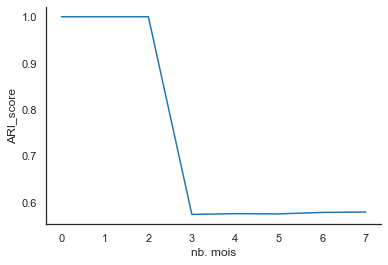

In [43]:
from sklearn.metrics import adjusted_rand_score


def plot_ari(df):
    df_ari = pd.DataFrame([], columns={'nb. mois', 'ARI_score'})
    for i in range(0, 8):
        if f'fit_t{i}' in df.columns:
            # filtre par données du mois
            df_ti = df.dropna(subset=[f'fit_t{i}'])
            df_ari = df_ari.append({
                'nb. mois': i,
                'ARI_score': adjusted_rand_score(df_ti[f'fit_t{i}'], df_ti[f'pred_t{i}'])
            }, ignore_index=True)
    sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score')
    sns.despine()


plot_ari(df_clusters)


### 3.7.2 Détection de le nombre de clusters k les plus stables

Automation pour détecter le nombre de clusters plus stable


k=4, completed in (time = 7.89 s)
k=5, completed in (time = 9.22 s)
k=6, completed in (time = 11.24 s)
k=7, completed in (time = 13.87 s)
k=8, completed in (time = 18.79 s)
"Stability_des_clusters_-_effet_de_changer_le_nombre_de_clusters.png"


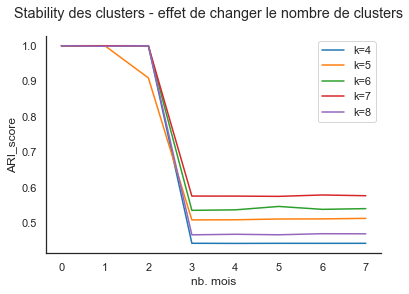

In [44]:
from time import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score

MODEL = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', KMeans(n_clusters=8))
])


def test_stabilite(df, model=MODEL, k=7, features=FEATURES,
                   date_col='dernier_achat', t0=START_DATE):
    """ automatisation pour détecter les clusters les plus stables"""
    df_ari = pd.DataFrame(
        [], columns={'k', 't0', 'n', 'nb. mois', 'ARI_score'})
    df_t0 = factory_one_year_dataset(
        df, start_date=t0, date_col=date_col)[features]
    params = {'clf__n_clusters': k}
    model_t0 = clone(model)
    model_t0.set_params(**params)
    model_t0.fit(df_t0[features])
    fit_t0_ = model_t0.named_steps['clf'].labels_
    pred_t0_ = model_t0.predict(df_t0[features])
    df_ari = df_ari.append({'k': k, 't0': f'{t0:%d%m%Y}', 'n': len(df_t0), 'nb. mois': 0,
                            'ARI_score': adjusted_rand_score(fit_t0_, pred_t0_)}, ignore_index=True)

    for mois in range(1, 8):
        df_tN_ = factory_one_year_dataset(df, t0 + pd.DateOffset(months=mois))
        model_tN_ = clone(model)
        model_tN_.set_params(**params)
        fit_tN_ = model_tN_.fit(df_tN_[features]).named_steps['clf'].labels_
        pred_tN_ = model_t0.predict(df_tN_[features])
        df_ari = df_ari.append({'k': k, 't0': f'{t0:%d%m%Y}', 'n': len(df_t0), 'nb. mois': mois,
                                'ARI_score': adjusted_rand_score(fit_tN_, pred_tN_)}, ignore_index=True)
        df_ari['k'] = df_ari['k'].astype('category')

    return df_ari


def test_stabilite_versus_k(df, model=MODEL, k_range=range(4, 9)):
    ax = None
    for k in k_range:
        start = time()
        df_ari = test_stabilite(df, model, k=k)
        print(f'k={k}, completed in (time = {round((time()-start), 2)} s)')
        ax = sns.lineplot(data=df_ari, x='nb. mois',
                          y='ARI_score', label=f'k={k}', ax=ax)

    sns.despine()
    plt.suptitle(
        'Stability des clusters - effet de changer le nombre de clusters')
    to_png()


test_stabilite_versus_k(df_clients)


### 3.7.3 Test de la stabilité, avec IsolationForest pour la suppression des outliers

Dans la proceedure **run_fit_model**, on elimine les outliers avant fir des clusters avec Isolation Forest.

On test si ça améliore la stabilité des clusters


k=4, completed in (time = 9.03 s)
k=5, completed in (time = 12.2 s)
k=6, completed in (time = 14.71 s)
k=7, completed in (time = 16.3 s)
k=8, completed in (time = 19.74 s)
"Stability_des_clusters_-_effet_de_changer_le_nombre_de_clusters.png"


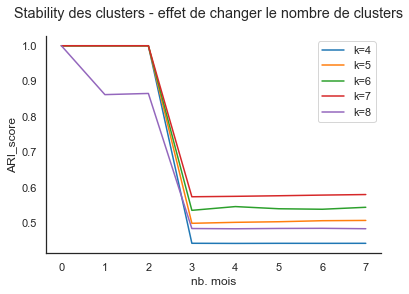

In [45]:

def test_stability(df, model, features=FEATURES, k=7,
                   date_col='dernier_achat', t0=START_DATE,
                   random_state=RANDOM_SEED, percent_outliers=0.5):
    """ automatisation pour détecter les clusters les plus stables"""
    df_ari = pd.DataFrame(
        [], columns={'k', 't0', 'n', 'nb. mois', 'ARI_score'})
    df_t0 = factory_one_year_dataset(df, start_date=t0, date_col=date_col)
    df_t0, fitted_model_T0 = run_fit_model(df_t0, model, features, k=k, cluster_col='fit_t0',
                                           remove_outliers_during_fit=True, percent_outliers=percent_outliers, random_state=random_state)
    df_t0['pred_t0'] = fitted_model_T0.predict(df_t0[features])
    df_ari = df_ari.append({'k': k, 't0': f'{t0:%d%m%Y}', 'n': len(df_t0), 'nb. mois': 0,
                            'ARI_score': adjusted_rand_score(df_t0['fit_t0'], df_t0['pred_t0'])}, ignore_index=True)

    for mois in range(1, 8):
        df_TN = factory_one_year_dataset(df, t0 + pd.DateOffset(months=mois))
        df_TN, _ = run_fit_model(df_TN, model, features, k=k, cluster_col=f'fit_t{mois}',
                                 remove_outliers_during_fit=True, percent_outliers=percent_outliers, random_state=random_state)
        df_TN[f'pred_t{mois}'] = fitted_model_T0.predict(df_TN[features])
        df_ari = df_ari.append({'k': k, 't0': f'{t0:%d%m%Y}', 'n': len(df_t0), 'nb. mois': mois,
                                'ARI_score': adjusted_rand_score(df_TN[f'fit_t{mois}'], df_TN[f'pred_t{mois}'])}, ignore_index=True)
        df_ari['k'] = df_ari['k'].astype('category')

    return df_ari


def test_stability_versus_k(df, model=MODEL, k_range=range(4, 9)):
    ax = None
    for k in k_range:
        start = time()
        df_ari = test_stability(df, model, k=k, percent_outliers=0)
        print(f'k={k}, completed in (time = {round((time()-start), 2)} s)')
        ax = sns.lineplot(data=df_ari, x='nb. mois',
                          y='ARI_score', label=f'k={k}', ax=ax)

    sns.despine()
    plt.suptitle(
        'Stability des clusters - effet de changer le nombre de clusters')
    to_png()


test_stability_versus_k(df_clients)


Il semble que l'exclusion d'outliers par isolation forest a l'effet de destabiliser les clusters


### 3.7.4 Choix de périod de maintenance

On choisi le nombre de clusters egal à 7, et les clusters de reference celles de janvier 2018


# 4. Evolution des clusters dans le temps

Pour suivre l'evolution des clusters dans le temps, il faut être sur que les cluster_id sont comparable pour chaque fit.

Neanmoins, KMeans est initialisé aléatoirement, donc les cluster_id seront attribués aléatoirement à chaque cluster.

Pour comparer les clusters temporellement, on crée un nom pour chaque cluster en 2 étapes:

- Présenter les clusters par ordre d'importance : renommer les cluster ids en ordre de score pour la colonne
- (Semi-)manuellement donner des noms à chaque cluster


### 4.1 Cluster labels attribués par KMeans


In [46]:
for i in range(1, 3):
    print('----------------------------')
    print(f'Fitted at t{i} versus model_t0.predict cluster for data at t{i}')
    print(pd.crosstab(df_clusters[f'fit_t{i}'], df_clusters[f'pred_t{i}']))


----------------------------
Fitted at t1 versus model_t0.predict cluster for data at t1
pred_t1     0      1      2     3     4     5     6
fit_t1                                             
0           0      0      0     0  1977     0     0
1           0  13052      0     0     0     0     0
2           0      0  12208     0     0     0     0
3           0      0      0     0     0  7313     0
4        6671      0      0     0     0     0     0
5           0      0      0     0     0     0  1235
6           0      0      0  2442     0     0     0
----------------------------
Fitted at t2 versus model_t0.predict cluster for data at t2
pred_t2     0      1      2     3     4     5     6
fit_t2                                             
0           0  13846      0     0     0     0     0
1        7269      0      0     0     0     0     0
2           0      0  13004     0     0     0     0
3           0      0      0  2925     0     0     0
4           0      0      0     0     0  7

## 4.2 Renommer les cluster ids en ordre de score pour la colonne


In [47]:
def rename_clusters(df):
    df = df.copy()
    label_maps = {}
    for i in range(0, 8):
        if f'fit_t{i}' in df.columns:
            label_maps[f't{i}'] = create_label_map(df, f'fit_t{i}')
            # apply label map for model ti on fitted data
            labelmap_ti = label_maps[f't{i}']
            df[f'fit_t{i}'] = df[f'fit_t{i}'].astype(
                str).map(label_maps[f't{i}'])
            df[f'pred_t{i}'] = df[f'pred_t{i}'].astype(
                str).map(label_maps['t0'])
    df_label_maps = pd.DataFrame(label_maps)
    return df, label_maps, df_label_maps


df_clusters2, lm, df_label_maps = rename_clusters(df_clusters)
df_label_maps


t0     t1     t2     t3     t4     t5     t6     t7
6  Seg 1  Seg 6  Seg 1  Seg 1  Seg 1  Seg 1  Seg 4  Seg 2
1  Seg 2  Seg 2  Seg 5  Seg 3  Seg 3  Seg 6  Seg 7  Seg 3
5  Seg 3  Seg 1  Seg 7  Seg 5  Seg 4  Seg 3  Seg 1  Seg 5
2  Seg 4  Seg 4  Seg 4  Seg 7  Seg 7  Seg 7  Seg 6  Seg 7
0  Seg 5  Seg 7  Seg 2  Seg 6  Seg 6  Seg 5  Seg 3  Seg 6
3  Seg 6  Seg 3  Seg 6  Seg 2  Seg 5  Seg 2  Seg 2  Seg 4
4  Seg 7  Seg 5  Seg 3  Seg 4  Seg 2  Seg 4  Seg 5  Seg 1

In [48]:
df_clusters2.head()


dernier_achat  Frequency  \
customer_unique_id                                                
e2ce734f0bd635b4b82317b5e5fcd152 2017-11-01 15:25:12          2   
d4842aa226d96a1cce7414b48c1dba85 2018-07-07 14:02:43          1   
97b27e8f7862217bae2f5bbc66e15b77 2018-05-18 19:56:54          1   
a15630ebd61b2a42d78cb93fbebeda88 2017-08-08 21:04:16          1   
9cfa9dd746cc855cc86fbd3b455ed20e 2017-06-29 15:27:53          1   

                                  MonetaryValue  Recency  mean_nb_payments  \
customer_unique_id                                                           
e2ce734f0bd635b4b82317b5e5fcd152          80.15      349              2.00   
d4842aa226d96a1cce7414b48c1dba85          32.43      101              1.00   
97b27e8f7862217bae2f5bbc66e15b77         227.66      151              2.00   
a15630ebd61b2a42d78cb93fbebeda88          97.87      434              1.00   
9cfa9dd746cc855cc86fbd3b455ed20e          42.59      474              2.00   

                                  review_score  delivery_time  delivery_delay  \
customer_unique_id                                                              
e2ce734f0bd635b4b82317b5e5fcd152          4.00           9.00          -17.50   
d4842aa226d96a1cce7414b48c1dba85          1.00           5.00           -6.00   
97b27e8f7862217bae2f5bbc66e15b77          5.00          25.00          -20.00   
a15630ebd61b2a42d78cb93fbebeda88          4.00           5.00           -9.00   
9cfa9dd746cc855cc86fbd3b455ed20e          4.00          10.00          -23.00   

                                  distance_customer_seller  freight_percent  \
customer_unique_id                                                            
e2ce734f0bd635b4b82317b5e5fcd152                    645.09             0.20   
d4842aa226d96a1cce7414b48c1dba85                     10.00             0.23   
97b27e8f7862217bae2f5bbc66e15b77                    318.06             0.12   
a15630ebd61b2a42d78cb93fbebeda88                      9.56             0.08   
9cfa9dd746cc855cc86fbd3b455ed20e                    290.61             0.30   

                                 payment_mode favourite_category  \
customer_unique_id                                                 
e2ce734f0bd635b4b82317b5e5fcd152  credit_card            leisure   
d4842aa226d96a1cce7414b48c1dba85       boleto        office_tech   
97b27e8f7862217bae2f5bbc66e15b77  credit_card    diy_garden_auto   
a15630ebd61b2a42d78cb93fbebeda88       boleto      health_parfum   
9cfa9dd746cc855cc86fbd3b455ed20e  credit_card    diy_garden_auto   

                                 customer_state favourite_seller_state  \
customer_unique_id                                                       
e2ce734f0bd635b4b82317b5e5fcd152             RS                     SC   
d4842aa226d96a1cce7414b48c1dba85             SP                     SP   
97b27e8f7862217bae2f5bbc66e15b77             RJ                     SP   
a15630ebd61b2a42d78cb93fbebeda88             SP                     SP   
9cfa9dd746cc855cc86fbd3b455ed20e             SP                     SP   

                                  time_of_day  weekday  products_per_order  \
customer_unique_id                                                           
e2ce734f0bd635b4b82317b5e5fcd152        15.00     2.00                1.00   
d4842aa226d96a1cce7414b48c1dba85        14.00     5.00                1.00   
97b27e8f7862217bae2f5bbc66e15b77        19.00     4.00                1.00   
a15630ebd61b2a42d78cb93fbebeda88        21.00     1.00                1.00   
9cfa9dd746cc855cc86fbd3b455ed20e        15.00     3.00                1.00   

                                        date year_month     t0     t1     t2  \
customer_unique_id                                                             
e2ce734f0bd635b4b82317b5e5fcd152  2017-11-01    2017_11   True   True   True   
d4842aa226d96a1cce7414b48c1dba85  2018-07-07    2018_07  False  False  False   
97b27e8f7862217bae2f5bbc66e15b77  201

In [49]:
for i in range(1, 3):
    print('----------------------------')
    print(f'Fitted at t{i} versus model_t0.predict cluster for data at t{i}')
    print(pd.crosstab(df_clusters2[f'fit_t{i}'], df_clusters2[f'pred_t{i}']))


----------------------------
Fitted at t1 versus model_t0.predict cluster for data at t1
pred_t1  Seg 1  Seg 2  Seg 3  Seg 4  Seg 5  Seg 6  Seg 7
fit_t1                                                  
Seg 1     1235      0      0      0      0      0      0
Seg 2        0  13052      0      0      0      0      0
Seg 3        0      0   7313      0      0      0      0
Seg 4        0      0      0  12208      0      0      0
Seg 5        0      0      0      0   6671      0      0
Seg 6        0      0      0      0      0   2442      0
Seg 7        0      0      0      0      0      0   1977
----------------------------
Fitted at t2 versus model_t0.predict cluster for data at t2
pred_t2  Seg 1  Seg 2  Seg 3  Seg 4  Seg 5  Seg 6  Seg 7
fit_t2                                                  
Seg 1     1372      0      0      0      0      0      0
Seg 2        0  13846      0      0      0      0      0
Seg 3        0      0   7897      0      0      0      0
Seg 4        0      0   

In [50]:
for i in range(3, 5):
    print('----------------------------')
    print(f'Fitted at t{i} versus model_t0.predict cluster for data at t{i}')
    print(pd.crosstab(df_clusters2[f'fit_t{i}'], df_clusters2[f'pred_t{i}']))


----------------------------
Fitted at t3 versus model_t0.predict cluster for data at t3
pred_t3  Seg 1  Seg 2  Seg 3  Seg 4  Seg 5  Seg 6  Seg 7
fit_t3                                                  
Seg 1      745      0      0      0      0      0      0
Seg 2      755      0      0      0      0     38     25
Seg 3        0  10844      0   2074      0      0      0
Seg 4        0      0   6017      0   1322      0      0
Seg 5        0   4073      0  12127      0      0      0
Seg 6        0      0   2375      0   6530      0      0
Seg 7        0      0      0      0      0   3070   2455
----------------------------
Fitted at t4 versus model_t0.predict cluster for data at t4
pred_t4  Seg 1  Seg 2  Seg 3  Seg 4  Seg 5  Seg 6  Seg 7
fit_t4                                                  
Seg 1      814      0      0      0      0      0      0
Seg 2      821      0      0      0      0     37     23
Seg 3        0  11392      0   2200      0      0      0
Seg 4        0      0   

In [51]:
for i in range(5, 7):
    print('----------------------------')
    print(f'Fitted at t{i} versus model_t0.predict cluster for data at t{i}')
    print(pd.crosstab(df_clusters2[f'fit_t{i}'], df_clusters2[f'pred_t{i}']))


----------------------------
Fitted at t5 versus model_t0.predict cluster for data at t5
pred_t5  Seg 1  Seg 2  Seg 3  Seg 4  Seg 5  Seg 6  Seg 7
fit_t5                                                  
Seg 1      864      0      0      0      0      0      0
Seg 2      867      0      0      0      0     36     24
Seg 3        0  12048      0   2475      0      0      0
Seg 4        0      0   6520      0   1507      0      0
Seg 5        0   4325      0  13636      0      0      0
Seg 6        0      0   2489      0   7093      0      0
Seg 7        0      0      0      0      0   3301   2643
----------------------------
Fitted at t6 versus model_t0.predict cluster for data at t6
pred_t6  Seg 1  Seg 2  Seg 3  Seg 4  Seg 5  Seg 6  Seg 7
fit_t6                                                  
Seg 1      922      0      0      0      0      0      0
Seg 2      900      0      0      0      0     34     24
Seg 3        0  12501      0   2648      0      0      0
Seg 4        0      0   

Avec les clusters ordonnés par **'cluster score'**, on peut attribuer des libellés à chaque cluster


## 4.3 Noms des clusters pour chaque periode de temps

En regardant les scores sur un spider plot, on peut manuellement definir les **SEGMENT_LABELS** : Les profils de chaque segment, pour chaque période de temps

En gros, les 7 segments peuvent être décrit avec les règles suivants:

- Si score ('Frequency') > 2 : **Frequent**
- Si score ('Monetary') > 4 : **Grand**
- Si score ('Monetary') entre 2 et 4 : **Moyen**
- Si score ('Monetary') < 2 : **Petit**
- Si score ('Review') > 4 : **heureux**
- Si score ('Review') < 4 : **insatisfait**

Il y a de nombre d'autres nuances (voir analyse dans notebook 'Essais'), comme par exemple le nombre moyenne de paiements, les moyennes de paiement préférees, les catégories préférées.


### Clients de la période T0


2017-02-01 08:45:22
"Segmentation_des_clients_-_t0_(dernier_achat_entre_01-02-2017_et_31-01-2018).png"
{'seg 0': 2.62, 'seg 1': 29.75, 'seg 2': 16.44, 'seg 3': 27.41, 'seg 4': 14.75, 'seg 5': 5.08, 'seg 6': 3.96}


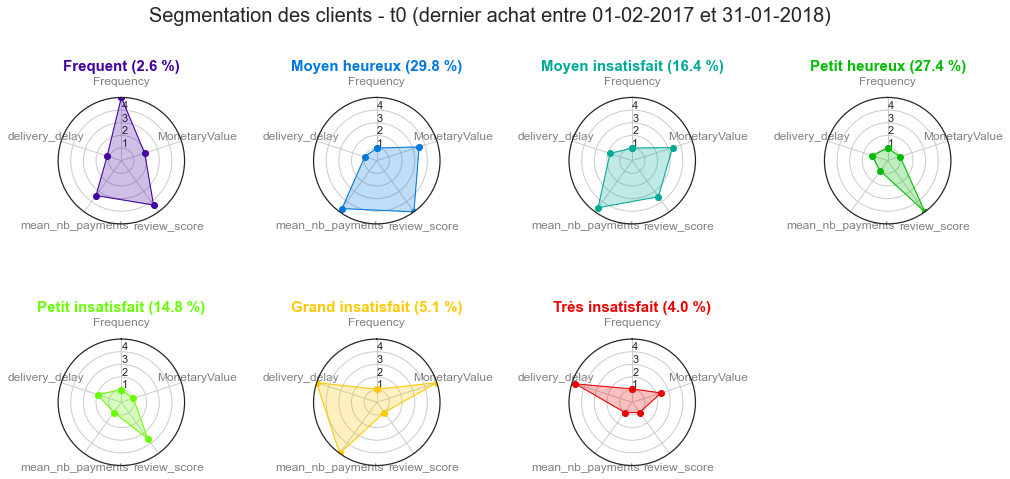

In [52]:
SEGMENT_LABELS_T0 = [
    'Frequent',
    'Moyen heureux',
    'Moyen insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Grand insatisfait',
    'Très insatisfait'
]


def plot_spider_fit(df, periode='t0',
                    segment_labels=None,
                    features=FEATURES, k=7):
    cluster_col = f'fit_{periode}'
    data = df.dropna(subset=[cluster_col])
    cluster_summary = group_clusters(df, cluster_col)
    metr = plot_spider(cluster_summary, features,
                       cluster_col=cluster_col, segment_labels=segment_labels)
    spider_title(data, k=k, periode=periode)
    to_png()
    return metr


metr = plot_spider_fit(df_clusters2, 't0',
                       SEGMENT_LABELS_T0)
print(metr)


### Clients de la période T1


2017-03-01 00:12:13
"Segmentation_des_clients_-_t1_(dernier_achat_entre_01-03-2017_et_28-02-2018).png"


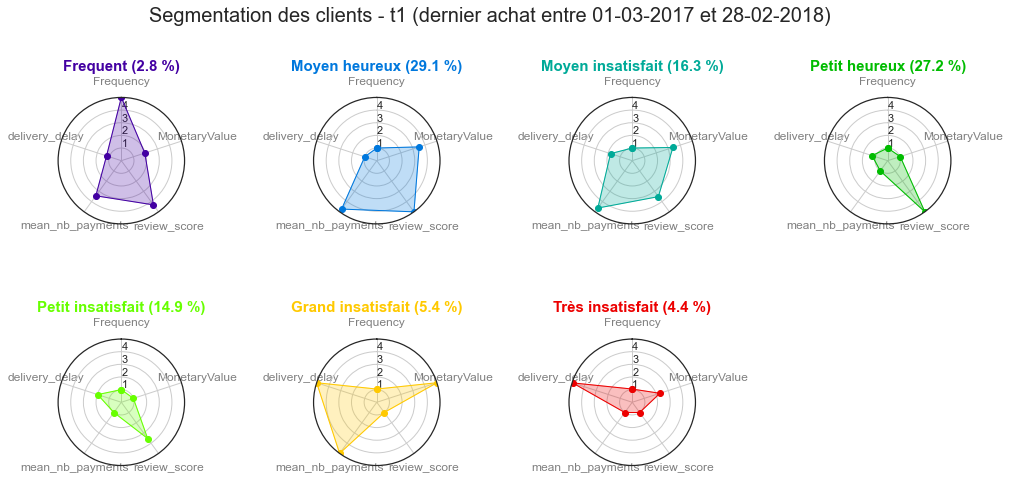

In [53]:
SEGMENT_LABELS_T1 = [
    'Frequent',
    'Moyen heureux',
    'Moyen insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Grand insatisfait',
    'Très insatisfait'
]
# metr = plot_spider_one_year_data(df_clients, 'T1',
#                                  START_DATE + pd.DateOffset(months=1),
#                                  SEGMENT_LABELS_T1)
# print(metr)
metr = plot_spider_fit(df_clusters2, 't1', SEGMENT_LABELS_T1)


### Clients de la période T2


2017-04-01 00:54:10
"Segmentation_des_clients_-_t2_(dernier_achat_entre_01-04-2017_et_31-03-2018).png"


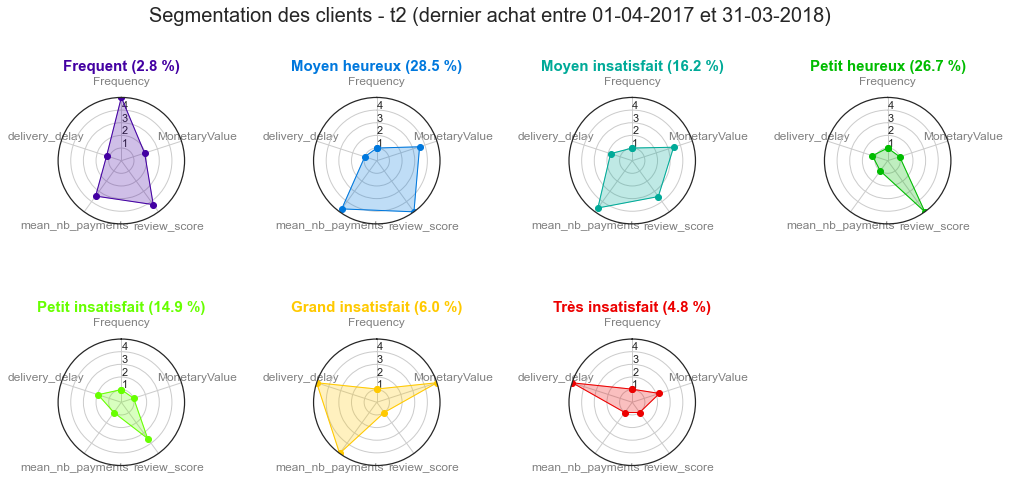

In [54]:
SEGMENT_LABELS_T2 = [
    'Frequent',
    'Moyen heureux',
    'Moyen insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Grand insatisfait',
    'Très insatisfait'
]
metr = plot_spider_fit(df_clusters2, 't2', SEGMENT_LABELS_T2)


### Clients de la période T3


2017-05-01 01:18:22
"Segmentation_des_clients_-_t3_(dernier_achat_entre_01-05-2017_et_30-04-2018).png"


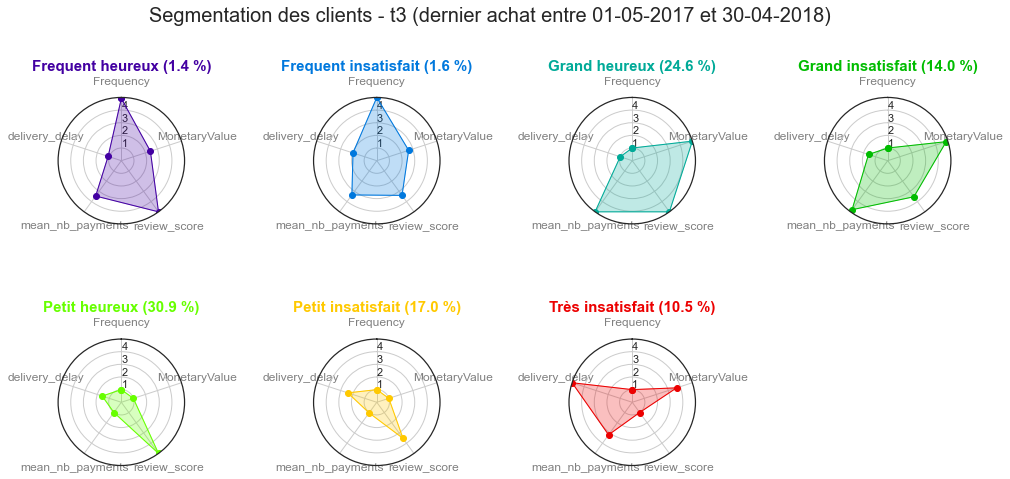

In [55]:
SEGMENT_LABELS_T3 = [
    'Frequent heureux',
    'Frequent insatisfait',
    'Grand heureux',
    'Grand insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Très insatisfait',
]
metr = plot_spider_fit(df_clusters2, 't3', SEGMENT_LABELS_T3)


### Clients de la période T4


2017-06-01 00:05:38
"Segmentation_des_clients_-_t4_(dernier_achat_entre_01-06-2017_et_31-05-2018).png"


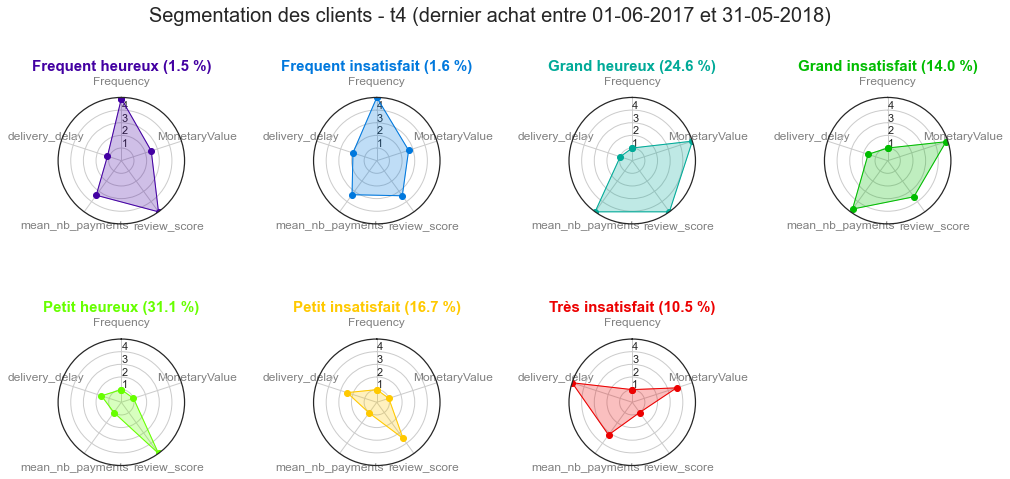

In [56]:
SEGMENT_LABELS_T4 = [
    'Frequent heureux',
    'Frequent insatisfait',
    'Grand heureux',
    'Grand insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Très insatisfait',
]
metr = plot_spider_fit(df_clusters2, 't4', SEGMENT_LABELS_T4)


### Clients de la période T5


2017-07-01 00:04:15
"Segmentation_des_clients_-_t5_(dernier_achat_entre_01-07-2017_et_30-06-2018).png"
{'seg 0': 1.49, 'seg 1': 1.6, 'seg 2': 25.11, 'seg 3': 13.88, 'seg 4': 31.06, 'seg 5': 16.57, 'seg 6': 10.28}


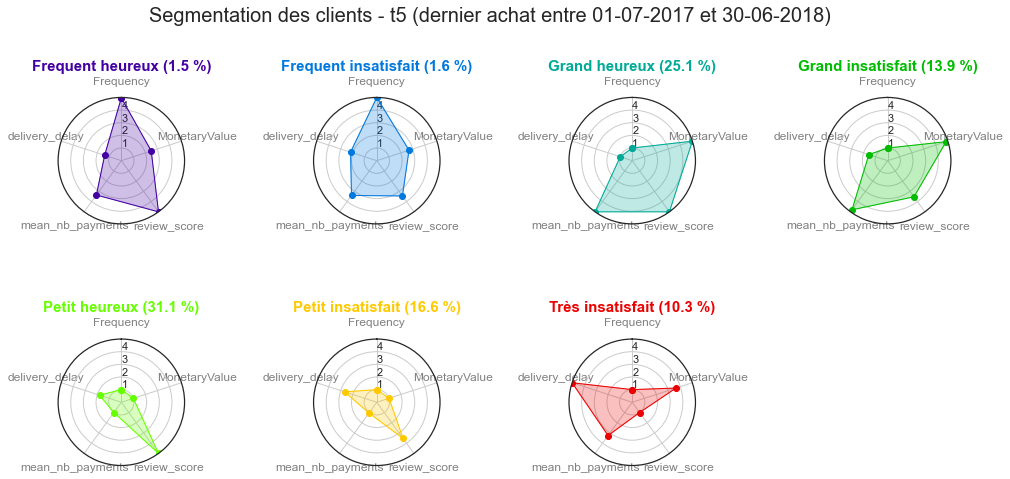

In [57]:
SEGMENT_LABELS_T5 = [
    'Frequent heureux',
    'Frequent insatisfait',
    'Grand heureux',
    'Grand insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Très insatisfait',
]
metr = plot_spider_fit(df_clusters2, 't5', SEGMENT_LABELS_T5)
print(metr)


### Clients de la période T6

Il semble être les même que T3


2017-08-01 00:02:01
"Segmentation_des_clients_-_t6_(dernier_achat_entre_01-08-2017_et_31-07-2018).png"
{'seg 0': 1.54, 'seg 1': 1.6, 'seg 2': 25.31, 'seg 3': 13.72, 'seg 4': 31.28, 'seg 5': 16.34, 'seg 6': 10.2}


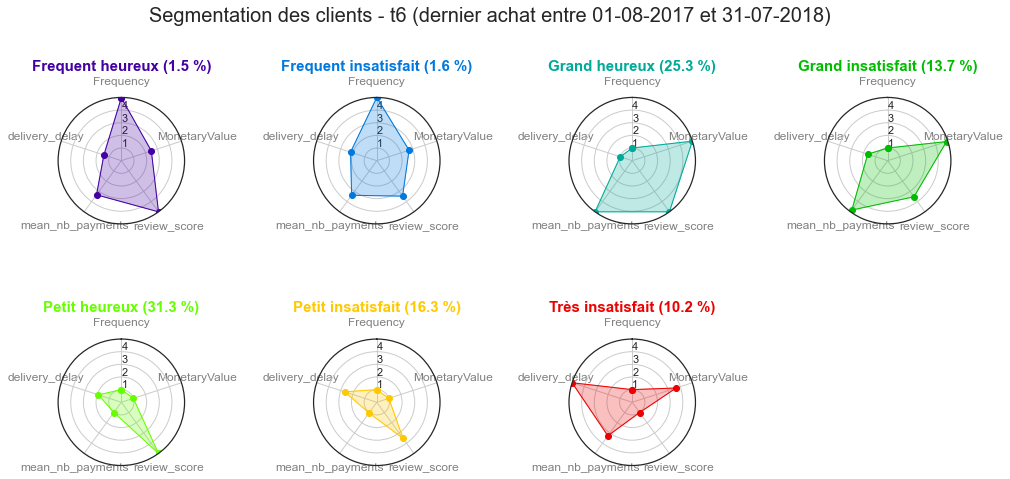

In [58]:
SEGMENT_LABELS_T6 = [
    'Frequent heureux',
    'Frequent insatisfait',
    'Grand heureux',
    'Grand insatisfait',
    'Petit heureux',
    'Petit insatisfait',
    'Très insatisfait',
]
metr = plot_spider_fit(df_clusters2, 't6', SEGMENT_LABELS_T6)
print(metr)


## 4.4 Evolution des clusters dans le temps (Sankey Diagram)

L'evolution des clusters dans le temps est fourni par la comparaison des groupes fitted par le model

- model*t0.fit(df_t0).labels*
- model*t1.fit(df_t1).labels*
- model*t2.fit(df_t2).labels*
- model*t3.fit(df_t3).labels*
- etc

On utilise les libéllés attribués mannuellement à chaque segment pour chaque période de temps

- <https://coderzcolumn.com/tutorials/data-science/how-to-plot-sankey-diagram-in-python-jupyter-notebook-holoviews-and-plotly>


In [59]:
segs = [f'Seg {i}' for i in range(1, 8)]
seg_colors = sns.color_palette('nipy_spectral', n_colors=7).as_hex()
color_map = dict(zip(segs, seg_colors))


def rename_col_labels(df, col, segments=None):
    """
    Rename sorted cluster labels based solely on new names.
    Assumes that clusters have already been sorted by score and renamed to [Seg 1, Seg 2, Seg 3, ...]
    - This procedure allows to map to named customer segments like [Frequent, Loyal, Unhappy,...]
    """
    old_labels = sorted(list(df[col].unique()))
    if len(old_labels) == len(segments):
        labelmap = dict(zip(old_labels, segments))
        df = df.copy()
        df[col] = df[col].map(labelmap)
    return df


def get_flows(df, t1=0, t2=1, segments1=None, segments2=None):
    ct = pd.crosstab(df[f'fit_t{t1}'], df[f'fit_t{t2}'])
    data = pd.melt(ct.reset_index(), id_vars=f'fit_t{t1}')
    data.columns = [f'fit_t{t1}', f'fit_t{t2}', 'nb_clients']
    data = data[data['nb_clients'] > 0]
    data['src_color'] = data[f'fit_t{t1}'].map(color_map)
    if segments1:
        # names for clusters at flow start time t1
        data = data.pipe(rename_col_labels,
                         col=f'fit_t{t1}', segments=segments1)
        data[f'fit_t{t1}'] = f'T{t1} :' + data[f'fit_t{t1}'].astype(str)
    if segments2:
        # names for clusters at flow end time t2
        data = data.pipe(rename_col_labels,
                         col=f'fit_t{t2}', segments=segments2)
        data[f'fit_t{t2}'] = f'T{t2} :' + data[f'fit_t{t2}'].astype(str)
    data.columns = [f'source', f'dest', 'nb_clients', 'src_color']
    return data


df_sankey = pd.concat([
    get_flows(df_clusters2, 0, 1, SEGMENT_LABELS_T0, SEGMENT_LABELS_T1),
    get_flows(df_clusters2, 1, 2, SEGMENT_LABELS_T1, SEGMENT_LABELS_T2),
    get_flows(df_clusters2, 2, 3, SEGMENT_LABELS_T2, SEGMENT_LABELS_T3),
    get_flows(df_clusters2, 3, 4, SEGMENT_LABELS_T3, SEGMENT_LABELS_T4),
    get_flows(df_clusters2, 4, 5, SEGMENT_LABELS_T4, SEGMENT_LABELS_T5),
    get_flows(df_clusters2, 5, 6, SEGMENT_LABELS_T5, SEGMENT_LABELS_T6),
], axis=0).reset_index(drop=True)
df_sankey.head()


source                   dest  nb_clients src_color
0           T0 :Frequent           T1 :Frequent        1056   #4300a2
1      T0 :Moyen heureux      T1 :Moyen heureux       11777   #0078dd
2  T0 :Moyen insatisfait  T1 :Moyen insatisfait        6512   #00aa98
3      T0 :Petit heureux      T1 :Petit heureux       10786   #00bc00
4  T0 :Petit insatisfait  T1 :Petit insatisfait        5794   #67ff00

In [68]:
import holoviews as hv
from holoviews import opts, dim
# hv.extension('bokeh')

df_cmap = df_sankey[['source', 'src_color']]
cmap_list = dict(zip(df_cmap['source'], df_cmap['src_color']))

sankey1 = hv.Sankey(df_sankey, kdims=['source', 'dest'], vdims=['nb_clients'])

sankey1.opts(label_position='right', invert_yaxis=True,
             edge_color="source",  edge_line_width=2, cmap=cmap_list,
             edge_hover_fill_color="red",
             node_alpha=1.0, node_width=30, node_sort=True,
             margin=0, padding=0,
             width=800, height=600, bgcolor=None,
             title="Evolution de la segmentation client")



:Sankey   [source,dest]   (nb_clients)

# 5. Tests sur l'effet de random_state, outliers et start_date sur la stabilité des clusters

Ce partie est pour évaluer l'influence d'hyperparametres sur les conclusions de stabilité:
- si le model est initialisé avec random_state fixe
- si on change le pourcentage d'outliers exclus pendant le fit
- si on change le start date (date de référence)


In [61]:
def test_clusters_stability(df, model, k_range=range(4, 9), t0=START_DATE, percent_outliers=0.005, random_state=RANDOM_SEED):
    """test pour plusieurs valeurs de taille des clusters """
    scores = pd.DataFrame([])
    for k in k_range:
        df_ari = test_stability(
            df, model, k=k, t0=t0, percent_outliers=percent_outliers, random_state=random_state)
        df_ari['k'] = k
        ari_scores = list(np.round(df_ari['ARI_score'], 2))
        print(f'k={k}; ARI_scores={ari_scores}')
        scores = scores.append(df_ari, ignore_index=True)
    scores['k'] = scores['k'].astype('category')

    return scores


df_ari = test_clusters_stability(df_clients, model=MODEL, k_range=[
                                 4], percent_outliers=0.005)


k=4; ARI_scores=[1.0, 1.0, 1.0, 0.44, 0.44, 0.44, 0.44, 0.44]


In [62]:
# df_ari =test_clusters_stability(df_clients, model=MODEL,percent_outliers=0.02)
# sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
# sns.despine()
# plt.suptitle('Stabilité des clusters - percent_outliers=0.5%')
# to_png()


### Test l'effet de random_state sur la stabilité des clusters


k=4; ARI_scores=[1.0, 1.0, 1.0, 0.44, 0.44, 0.44, 0.44, 0.44]
k=5; ARI_scores=[1.0, 0.92, 0.91, 0.51, 0.51, 0.51, 0.51, 0.51]
k=6; ARI_scores=[1.0, 0.91, 1.0, 0.54, 0.55, 0.54, 0.54, 0.54]
k=7; ARI_scores=[1.0, 1.0, 1.0, 0.57, 0.58, 0.58, 0.58, 0.58]
k=8; ARI_scores=[1.0, 1.0, 1.0, 0.47, 0.47, 0.47, 0.47, 0.47]
"Stabilité_des_clusters_-_effet_de_random_state_=_1.png"


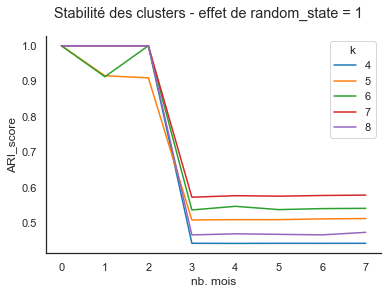

In [63]:
def test_ari_random_state(df, model=MODEL, random_state=None):
    df_ari = test_clusters_stability(df, model, random_state=random_state)
    sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
    sns.despine()
    plt.suptitle(
        f'Stabilité des clusters - effet de random_state = {random_state}')
    to_png()


test_ari_random_state(df_clients, random_state=1)


### Test l'effet des outliers sur la stabilité des clusters


k=4; ARI_scores=[1.0, 1.0, 1.0, 0.44, 0.44, 0.44, 0.44, 0.44]
k=5; ARI_scores=[1.0, 0.92, 0.91, 0.5, 0.5, 0.5, 0.51, 0.51]
k=6; ARI_scores=[1.0, 1.0, 1.0, 0.54, 0.54, 0.54, 0.55, 0.54]
k=7; ARI_scores=[1.0, 1.0, 1.0, 0.58, 0.58, 0.58, 0.58, 0.58]
k=8; ARI_scores=[1.0, 1.0, 1.0, 0.47, 0.47, 0.47, 0.47, 0.47]
"Stabilité_des_clusters_-_percent_outliers=0.png"


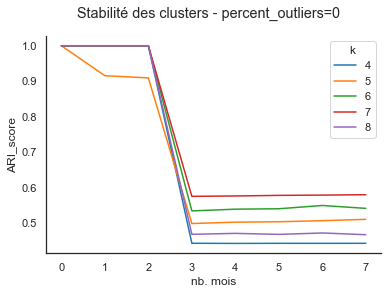

k=4; ARI_scores=[1.0, 1.0, 1.0, 0.44, 0.44, 0.44, 0.44, 0.44]
k=5; ARI_scores=[1.0, 0.92, 1.0, 0.5, 0.5, 0.5, 0.51, 0.51]
k=6; ARI_scores=[1.0, 1.0, 1.0, 0.54, 0.55, 0.55, 0.55, 0.55]
k=7; ARI_scores=[1.0, 1.0, 1.0, 0.47, 0.58, 0.47, 0.58, 0.58]
k=8; ARI_scores=[1.0, 0.86, 0.87, 0.47, 0.47, 0.47, 0.47, 0.48]
"Stabilité_des_clusters_-_percent_outliers=0-02.png"


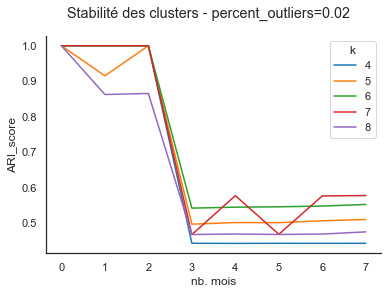

In [64]:
def test_ari_percent_outliers(df, model=MODEL, percent_outliers=0):
    df_ari = test_clusters_stability(
        df_clients, model=model, percent_outliers=percent_outliers)
    sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
    sns.despine()
    plt.suptitle(
        f'Stabilité des clusters - percent_outliers={percent_outliers}')
    to_png()


test_ari_percent_outliers(df_clients, percent_outliers=0)
plt.show()
test_ari_percent_outliers(df_clients, percent_outliers=0.02)


L'influence d'élimination des outliers pendant le clustering est très minimal:
- le QuantileTransformer est assez puissant pour réduire l'influence d'outliers
_ l'elimination d'outliers peuvent être exclu de notre modèle aveck=7

### Stabilité des clusters - effet de changer la période d'évaluation


k=4; ARI_scores=[1.0, 1.0, 1.0, 0.44, 0.44, 0.44, 0.44, 0.44]
k=5; ARI_scores=[1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.51, 0.51]
k=6; ARI_scores=[1.0, 1.0, 1.0, 0.54, 0.54, 0.54, 0.54, 0.54]
k=7; ARI_scores=[1.0, 1.0, 1.0, 0.57, 0.47, 0.58, 0.58, 0.58]
k=8; ARI_scores=[1.0, 0.86, 0.87, 0.48, 0.47, 0.47, 0.48, 0.47]
"Stabilité_des_clusters_-_start_date=01022017.png"


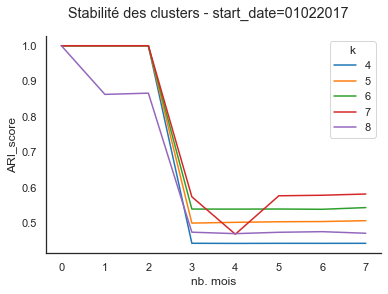

k=4; ARI_scores=[1.0, 1.0, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44]
k=5; ARI_scores=[1.0, 1.0, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51]
k=6; ARI_scores=[1.0, 1.0, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54]
k=7; ARI_scores=[1.0, 1.0, 0.57, 0.58, 0.58, 0.58, 0.58, 0.58]
k=8; ARI_scores=[1.0, 0.87, 0.47, 0.47, 0.47, 0.48, 0.47, 0.47]
"Stabilité_des_clusters_-_start_date=01032017.png"


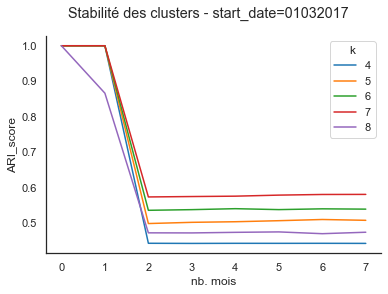

k=4; ARI_scores=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
k=5; ARI_scores=[1.0, 0.99, 0.99, 0.99, 0.98, 0.98, 0.97, 0.95]
k=6; ARI_scores=[1.0, 0.87, 0.98, 0.99, 1.0, 0.99, 0.99, 0.96]
k=7; ARI_scores=[1.0, 0.99, 0.98, 0.99, 0.99, 0.97, 0.97, 0.94]
k=8; ARI_scores=[1.0, 0.94, 0.97, 0.96, 0.97, 0.94, 0.94, 0.87]
"Stabilité_des_clusters_-_start_date=23082017.png"


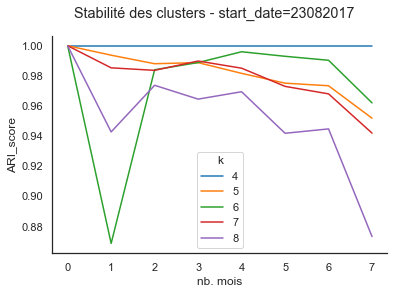

In [65]:
START_DATE2: datetime = pd.to_datetime('01/03/2017', format='%d/%m/%Y')
START_DATE3: datetime = pd.to_datetime('23/08/2017', format='%d/%m/%Y')


def test_ari_start_date(df, model=MODEL, start_date=START_DATE):
    df_ari = test_clusters_stability(
        df_clients, model=model, t0=start_date, percent_outliers=0)
    sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
    sns.despine()
    plt.suptitle(f'Stabilité des clusters - start_date={start_date:%d-%m-%Y}')
    to_png()

test_ari_start_date(df_clients, start_date=START_DATE)
plt.show()
test_ari_start_date(df_clients, start_date=START_DATE2)
plt.show()
test_ari_start_date(df_clients, start_date=START_DATE3)


On voit que la stabilité des clusters est très dépendant sur le start_date.

Neanmoins, le diagram Sankey a montré que même si les clusters perd leur stabilité, il reste similaire.
